# **Lab 7.1 Data Augmentation with PyTorch**

In [12]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.nn import functional as F
import random
import cv2
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt
import os

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return DataLoader() and print the information about the Dataset.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomAffine(degrees=45, translate=(0.1, 0.1),scale=(0.8, 1.2), shear=45)`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>), [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), [`Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=Preparing%20your%20data%20for%20training%20with%20DataLoaders)

In [13]:
def load_data(path):
	### START CODE HERE ###
	transform = transforms.Compose([
		transforms.Resize((224, 224)),
		transforms.ToTensor(),
		# transforms.RandomAffine(degrees=45, translate=(0.1, 0.1),scale=(0.8, 1.2), shear=45)
	])

	dataset = ImageFolder(path, transform=transform)
	data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)
	return (data_loader)
	### END CODE HERE ###

Use your load_data() function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114
```


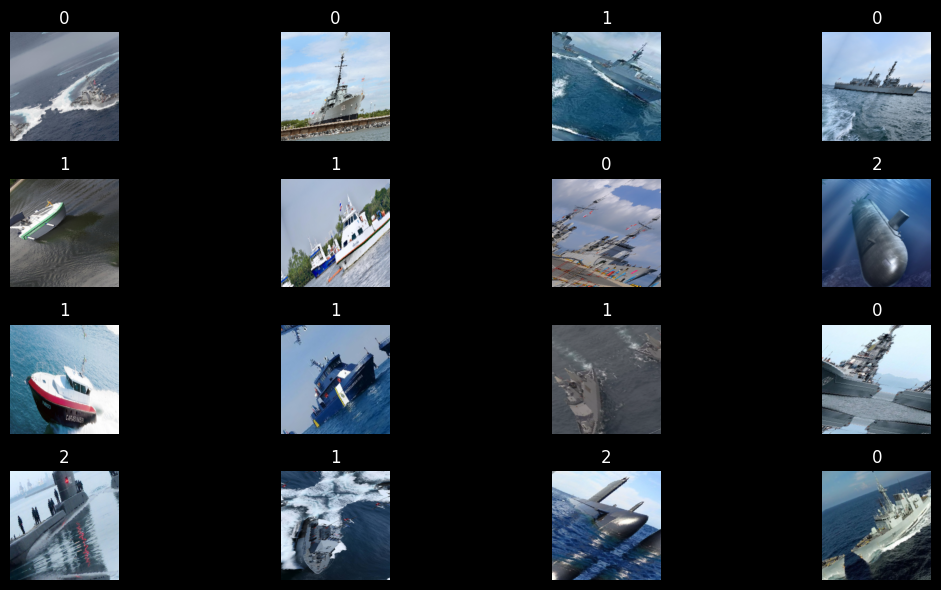

</details>

/home/tkrittithee/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114


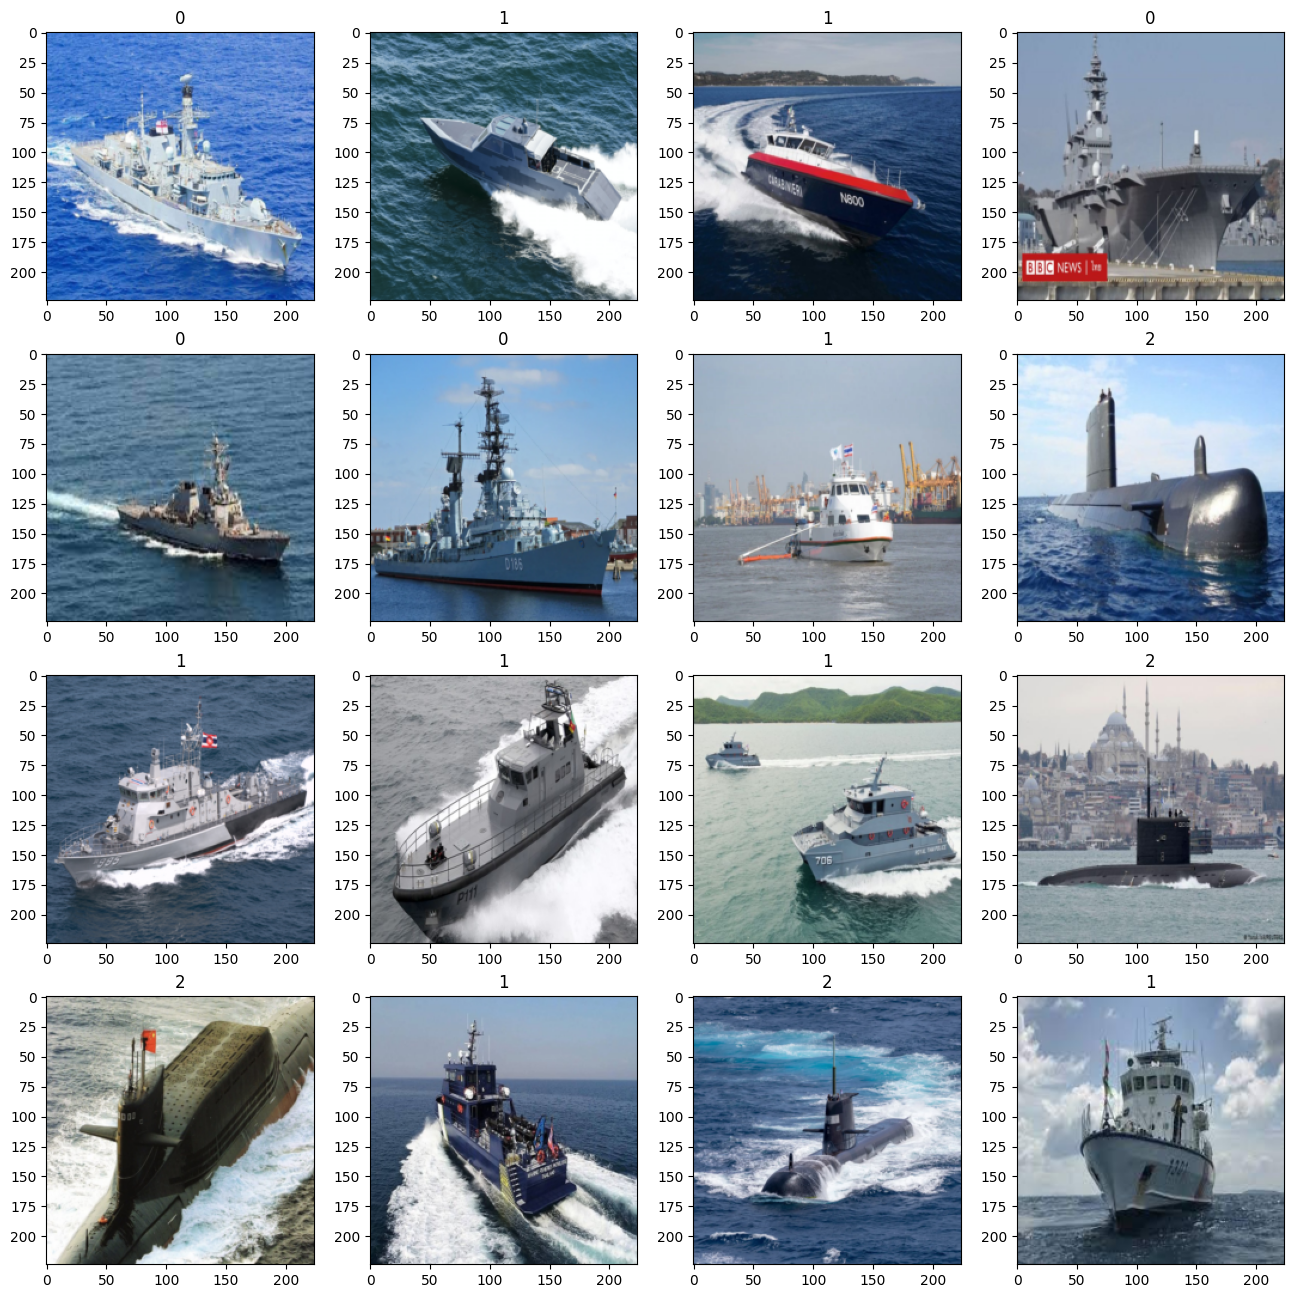

In [14]:
### START CODE HERE ###

from collections import Counter

data_loader = load_data("/home/tkrittithee/mai_workspace/repo/Lab7_Data-Augmentation-CNN/Ship/Train")
train_features, train_labels = next(iter(data_loader))

fig = plt.figure(figsize=(16,16))
axs = fig.subplots(4, 4)
i = 0
for img in train_features:
	row_index = i // 4
	column_index = i % 4
	img = np.transpose(img, (1, 2, 0))
	axs[row_index][column_index].set_title(str(train_labels[i].tolist()))
	axs[row_index][column_index].imshow(img)
	i += 1

labels = []
for feat, label in data_loader:
	labels.extend(label.tolist())

class_couts = Counter(labels)
print(f"Train Dataset:\n\tNumber of images in class battleship: {class_couts[0]}\n\tNumber of images in class patrol boat: {class_couts[1]}\n\tNumber of images in class submarine: {class_couts[2]}\n\tNumber of samples: 114")

### END CODE HERE ###

Now, let's create your own `CustomImageDataset` that performs the augmentation as in the previous section, but also includes the methods `add_gaussian_blur()` and `add_gaussian_noise()`. **<font color="red">DO NOT</font>** use `transforms.Compose()`.

Resource : [CustomImageDataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=.show()-,Dataset%20class,-torch.utils.data)

In [8]:
### START CODE HERE ###

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.dataset = ImageFolder(
            root, 
            # transform=transforms.Compose([
			# 	transforms.Resize((224, 224)),
			# 	transforms.ToTensor()
            # ])
        )

    def add_gaussian_blur(self, image):
        image = np.array(image)  # Convert PIL image to NumPy array
        return cv2.GaussianBlur(image, (5, 5), 0)

    def add_gaussian_noise(self, image):
        mean = 0
        sigma= 10
        gauss = np.random.normal(mean, sigma, image.shape)
        noisy = image.astype(np.float32) + gauss
        return np.clip(noisy, 0, 255).astype(np.uint8)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)
        image = cv2.resize(image, (224, 224))
        image = self.add_gaussian_blur(image)
        image = self.add_gaussian_noise(image)
        image = torch.tensor(image)
        return image, label

    def __len__(self):
        return len(self.dataset)


### END CODE HERE ###

Use your `CustomImageDataset()` function. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

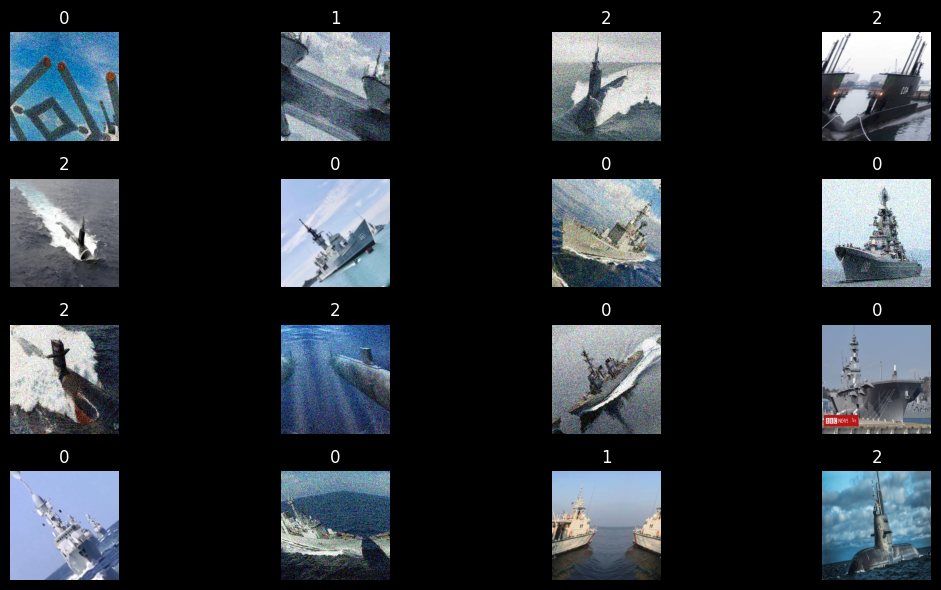

</details>

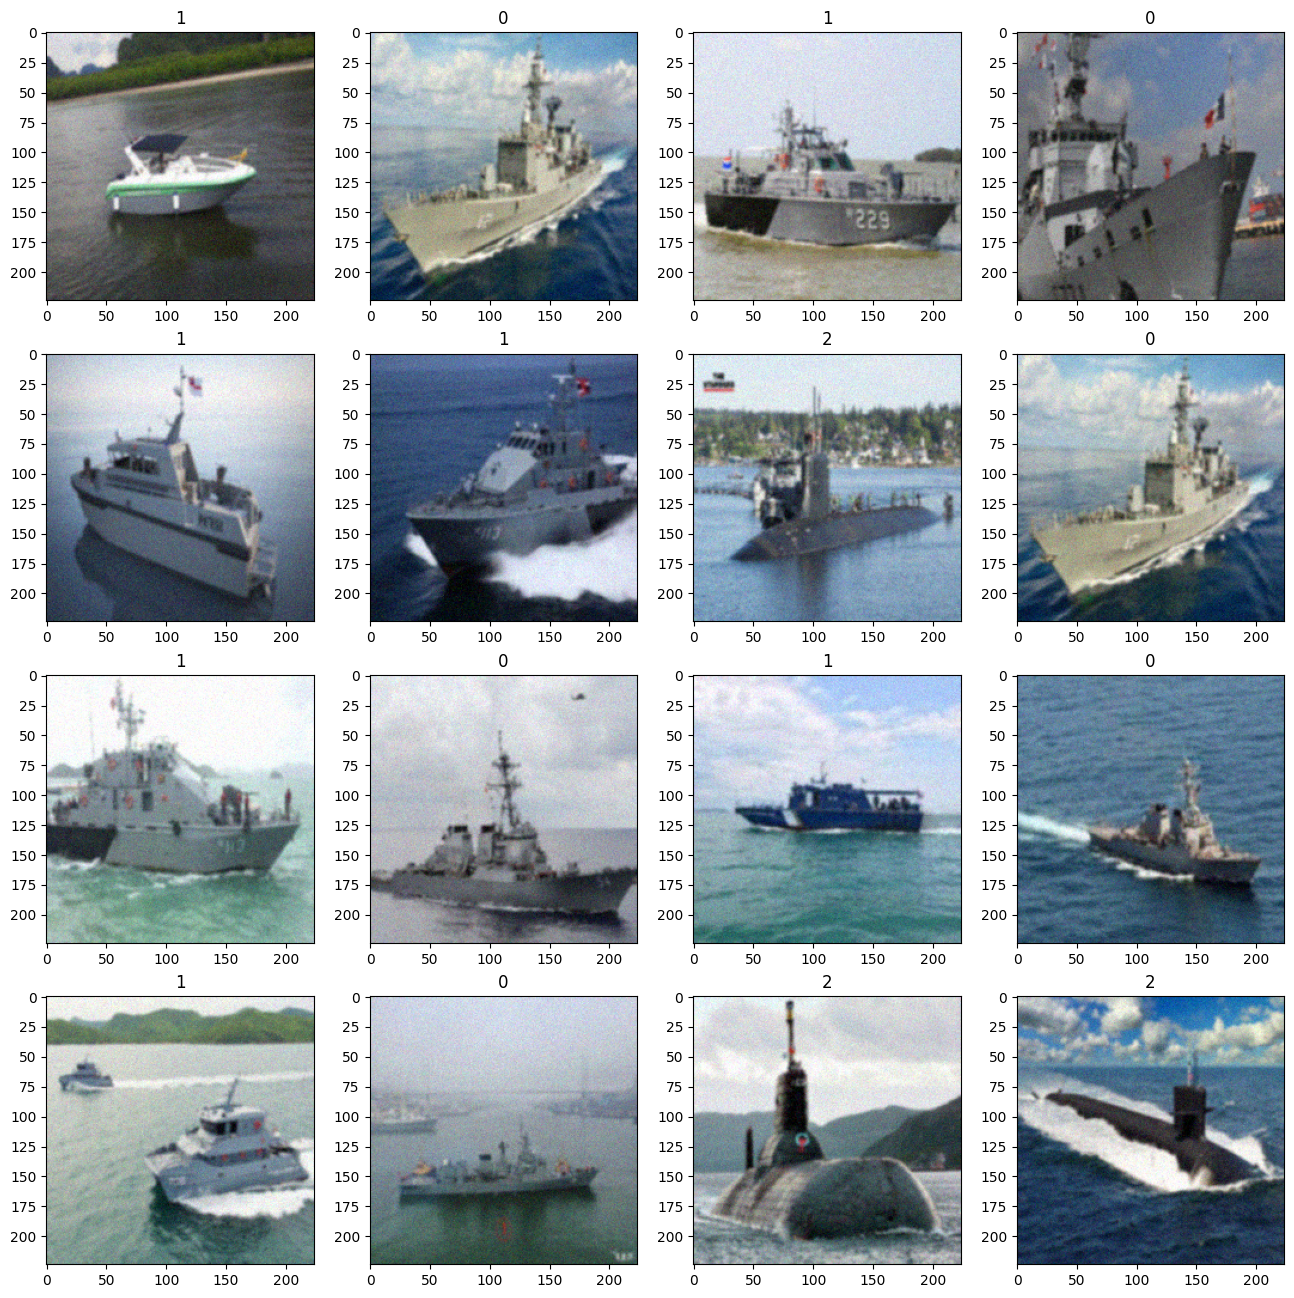

In [10]:
### START CODE HERE ###
dataset = CustomImageDataset("/home/tkrittithee/mai_workspace/repo/Lab7_Data-Augmentation-CNN/Ship/Train")

# Use DataLoader to load data in batches
data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
train_features, train_labels = next(iter(data_loader))


fig = plt.figure(figsize=(16,16))
axs = fig.subplots(4, 4)
i = 0
for img in train_features:
	row_index = i // 4
	column_index = i % 4
	axs[row_index][column_index].set_title(str(train_labels[i].tolist()))
	axs[row_index][column_index].imshow(img)
	i += 1

### END CODE HERE ###

---
# Questions
1. Discuss effects and benefits of fill_mode or padding_mode.
2. What would be amount of augmentation should be so that it would not effect the training performance?
3. How can we create Salt-and-Pepper Noise, which is the type that greatly affect the image quality?
4. What would be transform parameter to simulate camera lense effect?